 # ADDA for ST

In [48]:
import warnings
from math import ceil
import glob
import os
import datetime
from itertools import chain
from copy import deepcopy

from tqdm.autonotebook import tqdm

import h5py
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error

import torch
from torch.nn import functional as F
from torch import nn

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_MARKERS = 20
N_MIX = 8
N_SPOTS = 20000
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 512
NUM_WORKERS = 4
INITIAL_TRAIN_EPOCHS = 100

EARLY_STOP_CRIT = 100
MIN_EPOCHS = INITIAL_TRAIN_EPOCHS


EARLY_STOP_CRIT_ADV = 10
MIN_EPOCHS_ADV = 10

SPATIALLIBD_DIR = "./data/spatialLIBD"
SC_DLPFC_PATH = "./data/sc_dlpfc/adata_sc_dlpfc.h5ad"

PROCESSED_DATA_DIR = "./data/preprocessed"


In [50]:
results_folder = os.path.join("results", script_start_time)
model_folder = os.path.join("model_cell_dart", script_start_time)

model_folder = os.path.join("model_cell_dart", "TESTING")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)


In [51]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.6.0
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
leidenalg                   0.8.10
llvmlite                    0.38.0
matplotlib                  3.5.1
matplo

 # Define model components

In [52]:
class MLPEncoder(nn.Module):
    def __init__(self, inp_dim, emb_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(inp_dim, 1024),
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.99),
            nn.ELU(),
            nn.Linear(1024, emb_dim),
            nn.BatchNorm1d(emb_dim, eps=0.001, momentum=0.99),
            nn.ELU(),
        )

    def forward(self, x):
        return self.encoder(x)


In [53]:
class Classifier(nn.Module):
    def __init__(self, emb_dim, ncls_source):
        super().__init__()

        self.head = nn.Sequential(nn.Linear(emb_dim, ncls_source), nn.LogSoftmax(dim=1))

    def forward(self, x):
        return self.head(x)


In [54]:
class Discriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.BatchNorm1d(32, eps=0.001, momentum=0.99),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.head(x)


In [55]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad


In [56]:
class ADDAST(nn.Module):
    def __init__(self, inp_dim, emb_dim, ncls_source):
        super().__init__()

        self.source_encoder = MLPEncoder(inp_dim, emb_dim)
        self.target_encoder = MLPEncoder(inp_dim, emb_dim)
        self.clf = Classifier(emb_dim, ncls_source)
        self.dis = Discriminator(emb_dim)

        self.is_encoder_source = True

    def forward(self, x):
        if self.is_encoder_source:
            x = self.source_encoder(x)
        else:
            x = self.target_encoder(x)

        x = self.clf(x)

        return x

    def pretraining(self):
        self.is_encoder_source = True
        set_requires_grad(self.source_encoder, True)
        set_requires_grad(self.clf, True)

    def advtraining(self, train_dis=True):
        set_requires_grad(self.source_encoder, False)

        if train_dis:
            self.train_discriminator()
        else:
            self.train_target_encoder()

    def target_inference(self):
        self.is_encoder_source = False

    def train_discriminator(self):
        set_requires_grad(self.target_encoder, False)
        set_requires_grad(self.dis, True)

    def train_target_encoder(self):
        set_requires_grad(self.target_encoder, True)
        set_requires_grad(self.dis, False)

    def set_encoder(self, encoder="source"):
        if encoder == "source":
            self.is_encoder_source = True
        elif encoder == "target":
            self.is_encoder_source = False
        else:
            current_encoder_str = "'source'" if self.is_encoder_source else "'target'"
            warnings.warn(
                f"encoder parameter should be 'source' or 'target', got {encoder}; encoder is currently {current_encoder_str}",
                RuntimeWarning,
            )


In [57]:
class SpotDataset(torch.utils.data.Dataset):
    """Dataset for cell spots. Returns a spot with GEx data, and optionally cell type distribution"""

    def __init__(self, X, Y=None):
        """
        Args:
            X (array_like of rank 2): An (n_spots, n_genes) array of normalized log gene expression values.
            Y (array_like of rank 2, optional): An (n_spots, n_cell_types) array of cell type distribution.
        """
        super().__init__()

        self.X = torch.as_tensor(X).float()
        assert self.X.dim() == 2, f"X should be rank 2, got {self.X.dim()}"

        if Y is None:
            self.Y = torch.empty((self.X.shape[0], 0), dtype=torch.float)
        else:
            self.Y = torch.as_tensor(Y).float()
            assert self.Y.dim() == 2, f"Y should be rank 2, got {self.Y.dim()}"
            assert len(self.X) == len(self.Y), "X and Y unequal lengths"

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


 # Prepare Data
 ## Data load
 ### Load SpatialLIBD Data

In [58]:
# adata_dir = os.path.join(SPATIALLIBD_DIR, "adata")

# adata_spatialLIBD_d = {}

# for name in glob.glob(os.path.join(adata_dir, "adata_spatialLIBD-*.h5ad")):
#     sample_id = name.partition("-")[2].rpartition(".")[0]
#     # print(sample_id)
#     adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)


 ### Load Single Cell Data

In [59]:
# adata_sc_dlpfc = sc.read_h5ad(SC_DLPFC_PATH)
# sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e4)
# adata_sc_dlpfc.var_names_make_unique()


 ## Find Marker Genes

In [60]:
# Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])


In [61]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')


In [62]:
# df_genelists = pd.read_pickle("data/sc_dlpfc/df_genelists.pkl")
# res_genes = []
# for column in df_genelists.head(NUM_MARKERS):
#     res_genes.extend(df_genelists.head(NUM_MARKERS)[column].tolist())
# res_genes_ = list(set(res_genes))


 ### Select same gene features

In [63]:
# adata_spatialLIBD = ad.concat(
#     adata_spatialLIBD_d.values(), label="sample_id", keys=adata_spatialLIBD_d.keys()
# )
# adata_spatialLIBD.obs_names_make_unique()
# sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e4)
# st_sample_id_l = adata_spatialLIBD.obs["sample_id"].unique()


In [64]:
# adata_spatialLIBD.var_names_make_unique()
# inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
# print("Selected Feature Gene number", len(inter_genes))
# adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

# adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


 ## Format Data

### Array of single cell & spatial data
- Single cell data with labels
- Spatial data without labels


 ### Generate Pseudospots

In [65]:
# def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
#     """Creates a weighted average random sampling of gene expression, and the
#     corresponding weights.

#     Args:
#         X (:obj:, array_like of `float`): Matrix containing single cell samples
#             and their GEx profiles
#         y (:obj:, array_like of `int`): Array of cell type labels

#     Shape:
#         - X: `(N, C)`, where `N` is the number of single cell samples, and `C`
#         is the number of genes
#         - y: `(N,)`, where `N` is the number of single cell samples
#         - pseudo_gex: :math: `(N_{out}, C)` where
#         :math: `N_{out} = \text{n\_samples}` and `C` is the number of genes
#         - ctps: `(N_{out}, C_{types})`
#         where :math: `N_{out} = \text{n\_samples}` and :math: `C_{types}`
#         is the number of cell types.

#     Returns:
#          - pseudo_gex (ndarray): Matrix containing pseudo-spot samples and their
#          cell type proportion weighted averages
#          - ctps (ndarray): Matrix containing pseudo-spot samples and their cell
#          type proportions
#     """
#     # Define empty lists
#     pseudogexs, ys_new = [], []
#     ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

#     rstate = np.random.RandomState(seed)
#     fraction_all = rstate.rand(n_samples, nmix)
#     randindex_all = rstate.randint(len(Xs), size=(n_samples, nmix))

#     for i in range(n_samples):
#         # fraction: random fraction across the "nmix" number of sampled cells
#         fraction = fraction_all[i]
#         fraction = fraction / np.sum(fraction)
#         fraction = np.reshape(fraction, (nmix, 1))

#         # Random selection of the single cell data by the index
#         randindex = randindex_all[i]
#         ymix = ys_[randindex]
#         # Calculate the fraction of cell types in the cell mixture
#         yy = np.sum(ymix * fraction, axis=0)
#         # Calculate weighted gene expression of the cell mixture
#         XX = np.asarray(Xs[randindex]) * fraction
#         XX_ = np.sum(XX, axis=0)

#         # Add cell type fraction & composite gene expression in the list
#         ys_new.append(yy)
#         pseudogexs.append(XX_)

#     pseudogexs = np.asarray(pseudogexs)
#     ys_new = np.asarray(ys_new)

#     return pseudogexs, ys_new


In [66]:
# def log_minmaxscale(arr):
#     """returns log1pc and min/max normalized arr"""
#     arrd = len(arr)
#     arr = np.log1p(arr)

#     arr_minus_min = arr - np.reshape(np.min(arr, axis=1), (arrd, 1))
#     min2max = np.reshape((np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1))
#     return arr_minus_min / min2max


In [67]:
# df_sc = adata_sc_dlpfc.to_df()
# df_sc.index = pd.MultiIndex.from_frame(adata_sc_dlpfc.obs.reset_index())

# sc_sub_dict = dict(zip(range(df_genelists.shape[1]), df_genelists.columns.tolist()))
# sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())


In [68]:
# lab_sc_sub = df_sc.index.get_level_values("cell_subclass")
# lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
# lab_sc_num = np.asarray(lab_sc_num, dtype="int")

# mat_sc_train, mat_sc_eval, lab_sc_num_train, lab_sc_num_eval = train_test_split(
#     df_sc.to_numpy(),
#     lab_sc_num,
#     test_size=0.2,
#     random_state=225,
#     stratify=lab_sc_num,
# )

# mat_sc_val, mat_sc_test, lab_sc_num_val, lab_sc_num_test = train_test_split(
#     mat_sc_eval,
#     lab_sc_num_eval,
#     test_size=0.5,
#     random_state=263,
#     stratify=lab_sc_num_eval,
# )

# sc_mix_train, lab_mix_train = random_mix(
#     mat_sc_train, lab_sc_num_train, nmix=N_MIX, n_samples=N_SPOTS
# )
# sc_mix_val, lab_mix_val = random_mix(
#     mat_sc_val, lab_sc_num_val, nmix=N_MIX, n_samples=N_SPOTS // 8
# )
# sc_mix_test, lab_mix_test = random_mix(
#     mat_sc_test, lab_sc_num_test, nmix=N_MIX, n_samples=N_SPOTS // 8
# )


# sc_mix_train_s = log_minmaxscale(sc_mix_train)
# sc_mix_val_s = log_minmaxscale(sc_mix_val)
# sc_mix_test_s = log_minmaxscale(sc_mix_test)


 ### Format Spatial Data

In [69]:
# mat_sp_test_d = {}
# mat_sp_test_s_d = {}
# for sample_id in st_sample_id_l:
#     mat_sp_test_d[sample_id] = adata_spatialLIBD[
#         adata_spatialLIBD.obs.sample_id == sample_id
#     ].X.todense()

#     mat_sp_test_s_d[sample_id] = log_minmaxscale(mat_sp_test_d[sample_id])

# if TRAIN_USING_ALL_ST_SAMPLES:
#     mat_sp_train = adata_spatialLIBD.X.todense()
#     mat_sp_train_s = log_minmaxscale(mat_sp_train)
# else:
#     mat_sp_train_d = mat_sp_test_d
#     mat_sp_train_s_d = mat_sp_test_s_d


In [70]:
# Load spatial data
mat_sp_test_s_d = {}
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_test_s_d.hdf5"), "r") as f:
    for sample_id in f:
        mat_sp_test_s_d[sample_id] = f[sample_id][()]

if TRAIN_USING_ALL_ST_SAMPLES:
    with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s.hdf5"), "r") as f:
        mat_sp_train_s = f["all"][()]
else:
    mat_sp_train_s_d = mat_sp_test_s_d

# Load sc data
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "sc.hdf5"), "r") as f:
    sc_mix_train_s = f["X/train"][()]
    sc_mix_val_s = f["X/val"][()]
    sc_mix_test_s = f["X/test"][()]

    lab_mix_train = f["y/train"][()]
    lab_mix_val = f["y/val"][()]
    lab_mix_test = f["y/test"][()]

# Load helper dicts / lists
with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict.pkl"), "rb") as f:
    sc_sub_dict = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict2.pkl"), "rb") as f:
    sc_sub_dict2 = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "st_sample_id_l.pkl"), "rb") as f:
    st_sample_id_l = pickle.load(f)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [71]:
### source dataloaders
source_train_set = SpotDataset(deepcopy(sc_mix_train_s), deepcopy(lab_mix_train))
source_val_set = SpotDataset(deepcopy(sc_mix_val_s), deepcopy(lab_mix_val))
source_test_set = SpotDataset(deepcopy(sc_mix_test_s), deepcopy(lab_mix_test))

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_test_set_d = {}
for sample_id in st_sample_id_l:
    target_test_set_d[sample_id] = SpotDataset(deepcopy(mat_sp_test_s_d[sample_id]))

dataloader_target_test_d = {}
for sample_id in st_sample_id_l:
    dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
        target_test_set_d[sample_id],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )

if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(deepcopy(mat_sp_train_s))
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
else:
    target_train_set_d = {}
    dataloader_target_train_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_test_s_d[sample_id])
        )
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
        )


 ## Define Model

In [72]:
model = ADDAST(sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1])
model.to(device)


ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Classifier(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Lo

 ## Pretrain

In [73]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [74]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-07
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [75]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [76]:
model.pretraining()


In [77]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

# Train
print("Start pretrain...")
outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)
for epoch in range(INITIAL_TRAIN_EPOCHS):

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT and epoch > MIN_EPOCHS:
        print(
            f"Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch"
        )
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"earlystop_{epoch}.pth"))
        break

    early_stop_count += 1

    # Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  # force print final state
    inner.reset()  # reuse bar
    for _, batch in enumerate(dataloader_source_train):

        pre_optimizer.zero_grad()
        loss = model_loss(*batch, model)
        loss_running.append(loss.item())
        mean_weights.append(len(batch))  # we will weight average by batch size later

        loss.backward()
        pre_optimizer.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))
    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_val, model)
        loss_history_val.append(curr_loss_val)

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "train loss:",
        round(loss_history[-1], 6),
        "validation loss:",
        round(loss_history_val[-1], 6),
    )

# Save final model
checkpoint = {
    "epoch": epoch,
    "model": model,
    "optimizer": pre_optimizer,
}
torch.save(checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0 train loss: 1.247313 validation loss: 1.020385
epoch: 1 train loss: 0.885039 validation loss: 0.912773
epoch: 2 train loss: 0.70336 validation loss: 0.716765
epoch: 3 train loss: 0.621871 validation loss: 0.66815
epoch: 4 train loss: 0.586025 validation loss: 0.660249
epoch: 5 train loss: 0.559927 validation loss: 0.650651
epoch: 6 train loss: 0.541049 validation loss: 0.653696
epoch: 7 train loss: 0.523344 validation loss: 0.674063
epoch: 8 train loss: 0.50777 validation loss: 0.670034
epoch: 9 train loss: 0.498241 validation loss: 0.659916
epoch: 10 train loss: 0.483971 validation loss: 0.663603
epoch: 11 train loss: 0.471713 validation loss: 0.669276
epoch: 12 train loss: 0.46168 validation loss: 0.701341
epoch: 13 train loss: 0.448541 validation loss: 0.70499
epoch: 14 train loss: 0.432519 validation loss: 0.747047
epoch: 15 train loss: 0.420956 validation loss: 0.737349
epoch: 16 train loss: 0.410239 validation loss: 0.807706
epoch: 17 train loss: 0.400048 validation loss

 ## Adversarial Adaptation

In [78]:
N_ITER = 3000
EPOCHS = 1000
ALPHA_LR = 5
ALPHA = 1/0.6


In [79]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [80]:
def batch_generator(data, batch_size):
    """Generate batches of data.
    Given a list of numpy data, it iterates over the list and returns batches of
    the same size
    This
    """
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(
            all_examples_indices, size=batch_size, replace=False
        )
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr


In [81]:
criterion_dis = nn.CrossEntropyLoss()


def discrim_loss_accu(x, y_dis, model):
    x = x.to(torch.float32).to(device)

    emb = model.source_encoder(x)
    y_pred = model.dis(emb)

    loss = criterion_dis(y_pred, y_dis)

    accu = torch.mean(
        (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(torch.float32)
    ).cpu()

    return loss, accu


def compute_acc_dis(dataloader_source, dataloader_target, model):
    len_target = len(dataloader_target)
    len_source = len(dataloader_source)

    loss_running = []
    accu_running = []
    mean_weights = []
    model.eval()
    model.source_encoder.eval()
    model.dis.eval()
    with torch.no_grad():
        for y_val, dl in zip([1, 0], [dataloader_target, dataloader_source]):
            for _, (x, _) in enumerate(dl):

                y_dis = torch.full(
                    (x.shape[0],), y_val, device=device, dtype=torch.long
                )

                loss, accu = discrim_loss_accu(x, y_dis, model)

                accu_running.append(accu)
                loss_running.append(loss.item())

                # we will weight average by batch size later
                mean_weights.append(len(x))

    return (
        np.average(loss_running, weights=mean_weights),
        np.average(accu_running, weights=mean_weights),
    )


In [82]:
def train_adversarial(
    model,
    save_folder,
    sc_mix_train_s,
    lab_mix_train,
    mat_sp_train_s,
    dataloader_source_train_eval,
    dataloader_target_train_eval,
):

    model.to(device)
    model.advtraining()
    model.set_encoder("source")

    S_batches = batch_generator(
        [sc_mix_train_s.copy(), lab_mix_train.copy()], BATCH_SIZE
    )
    T_batches = batch_generator(
        [mat_sp_train_s.copy(), np.ones(shape=(len(mat_sp_train_s), 2))], BATCH_SIZE
    )

    enc_optimizer = torch.optim.Adam(
        chain(
            model.source_encoder.parameters(),
            model.dis.parameters(),
            model.clf.parameters(),
        ),
        lr=0.001,
        betas=(0.9, 0.999),
        eps=1e-07,
    )

    dis_optimizer = torch.optim.Adam(
        chain(model.source_encoder.parameters(), model.dis.parameters()),
        lr=ALPHA_LR * 0.001,
        betas=(0.9, 0.999),
        eps=1e-07,
    )

    # Initialize lists to store loss and accuracy values
    loss_history_running = []

    # Train
    print("Start adversarial training...")
    outer = tqdm(total=N_ITER, desc="Iterations", position=0)

    for iters in range(N_ITER):
        model.train()
        model.dis.train()
        model.clf.train()
        model.source_encoder.train()

        x_source, y_true = next(S_batches)
        x_target, _ = next(T_batches)

        ## Train encoder
        set_requires_grad(model.source_encoder, True)
        set_requires_grad(model.clf, True)
        set_requires_grad(model.dis, True)

        # save discriminator weights
        dis_weights = deepcopy(model.dis.state_dict())
        new_dis_weights = {}
        for k in dis_weights:
            if "num_batches_tracked" not in k:
                new_dis_weights[k] = dis_weights[k]

        dis_weights = new_dis_weights

        x_source, x_target, y_true, = (
            torch.Tensor(x_source),
            torch.Tensor(x_target),
            torch.Tensor(y_true),
        )
        x_source, x_target, y_true, = (
            x_source.to(device),
            x_target.to(device),
            y_true.to(device),
        )

        x = torch.cat((x_source, x_target))

        # save for discriminator later
        x_d = x.detach()

        # y_dis is the REAL one
        y_dis = torch.cat(
            [
                torch.zeros(x_source.shape[0], device=device, dtype=torch.long),
                torch.ones(x_target.shape[0], device=device, dtype=torch.long),
            ]
        )
        y_dis_flipped = 1 - y_dis.detach()

        emb = model.source_encoder(x).view(x.shape[0], -1)

        y_dis_pred = model.dis(emb)
        y_clf_pred = model.clf(emb)

        # we use flipped because we want to confuse discriminator
        loss_dis = criterion_dis(y_dis_pred, y_dis_flipped)

        # Set true = predicted for target samples since we don't know what it is
        y_clf_true = torch.cat((y_true, y_clf_pred[-x_target.shape[0] :].detach()))
        # Loss fn does mean over all samples including target
        loss_clf = criterion_clf(y_clf_pred, y_clf_true)

        # Scale back up loss so mean doesn't include target
        loss = (x.shape[0] / x_source.shape[0]) * loss_clf + ALPHA * loss_dis

        # loss = loss_clf + ALPHA * loss_dis

        enc_optimizer.zero_grad()
        loss.backward()
        enc_optimizer.step()

        model.dis.load_state_dict(dis_weights, strict=False)

        ## Train discriminator
        set_requires_grad(model.source_encoder, True)
        set_requires_grad(model.clf, True)
        set_requires_grad(model.dis, True)

        # save encoder and clf weights
        source_encoder_weights = deepcopy(model.source_encoder.state_dict())
        clf_weights = deepcopy(model.clf.state_dict())

        new_clf_weights = {}
        for k in clf_weights:
            if "num_batches_tracked" not in k:
                new_clf_weights[k] = clf_weights[k]

        clf_weights = new_clf_weights

        new_source_encoder_weights = {}
        for k in source_encoder_weights:
            if "num_batches_tracked" not in k:
                new_source_encoder_weights[k] = source_encoder_weights[k]

        source_encoder_weights = new_source_encoder_weights

        emb = model.source_encoder(x_d).view(x_d.shape[0], -1)
        y_pred = model.dis(emb)

        # we use the real domain labels to train discriminator
        loss = criterion_dis(y_pred, y_dis)

        dis_optimizer.zero_grad()
        loss.backward()
        dis_optimizer.step()

        model.clf.load_state_dict(clf_weights, strict=False)
        model.source_encoder.load_state_dict(source_encoder_weights, strict=False)

        # Save checkpoint every 100
        if iters % 100 == 99 or iters >= N_ITER - 1:
            checkpoint = {
                "epoch": iters,
                "model": model,
                "dis_optimizer": dis_optimizer,
                "enc_optimizer": enc_optimizer,
            }
            torch.save(checkpoint, os.path.join(save_folder, f"checkpt{iters}.pth"))

            model.eval()
            source_loss = compute_acc(dataloader_source_train_eval, model)
            _, dis_accu = compute_acc_dis(
                dataloader_source_train_eval, dataloader_target_train_eval, model
            )

            # Print the results
            print(
                "iter:",
                iters,
                "source loss:",
                round(source_loss, 6),
                # "dis loss:", round(np.average(loss_running[-100:], weights=mean_weights[-100:]), 6),
                "dis accu:",
                round(dis_accu, 6),
            )

        outer.update(1)

    # Save final model
    checkpoint = {
        "epoch": N_ITER,
        "model": model,
        "dis_optimizer": dis_optimizer,
        "enc_optimizer": enc_optimizer,
    }
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))


In [83]:
st_sample_id_l = [SAMPLE_ID_N]


In [84]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)
    model.advtraining()

    train_adversarial(
        model,
        save_folder,
        sc_mix_train_s,
        lab_mix_train,
        mat_sp_train_s,
        dataloader_source_train,
        dataloader_target_train,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
        model = best_checkpoint["model"]
        model.to(device)
        model.advtraining()

        train_adversarial(
            model,
            save_folder,
            sc_mix_train_s,
            lab_mix_train,
            mat_sp_train_s_d[sample_id],
            dataloader_source_train,
            dataloader_target_train_d[sample_id],
        )


Adversarial training for ST slide 151673: 
Start adversarial training...


Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.627458 dis accu: 0.261982
iter: 199 source loss: 1.325434 dis accu: 0.958628
iter: 299 source loss: 1.234094 dis accu: 0.824485
iter: 399 source loss: 1.231467 dis accu: 0.920259
iter: 499 source loss: 1.198013 dis accu: 0.941495
iter: 599 source loss: 1.127546 dis accu: 0.996277
iter: 699 source loss: 1.131435 dis accu: 0.862135
iter: 799 source loss: 1.10388 dis accu: 0.862304
iter: 899 source loss: 1.109815 dis accu: 0.7917
iter: 999 source loss: 1.121993 dis accu: 0.862262
iter: 1099 source loss: 1.066929 dis accu: 0.81704
iter: 1199 source loss: 1.041926 dis accu: 0.96455
iter: 1299 source loss: 1.004931 dis accu: 0.670164
iter: 1399 source loss: 0.986623 dis accu: 0.818986
iter: 1499 source loss: 0.982488 dis accu: 0.708871
iter: 1599 source loss: 0.939927 dis accu: 0.732857
iter: 1699 source loss: 0.888202 dis accu: 0.716908
iter: 1799 source loss: 0.86656 dis accu: 0.5169
iter: 1899 source loss: 0.868569 dis accu: 0.597826
iter: 1999 source loss: 0.85717

 ## 4. Predict cell fraction of spots and visualization

In [85]:
pred_sp_d, pred_sp_noda_d = {}, {}
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.set_encoder("source")
    with torch.no_grad():
        for sample_id in st_sample_id_l:
            pred_sp_d[sample_id] = (
                torch.exp(
                    model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
                )
                .detach()
                .cpu()
                .numpy()
            )


else:
    for sample_id in st_sample_id_l:
        best_checkpoint = torch.load(
            os.path.join(advtrain_folder, sample_id, f"final_model.pth")
        )
        model = best_checkpoint["model"]
        model.to(device)

        model.eval()
        model.set_encoder("source")

        with torch.no_grad():
            pred_sp_d[sample_id] = (
                torch.exp(
                    model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
                )
                .detach()
                .cpu()
                .numpy()
            )


best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

with torch.no_grad():
    for sample_id in st_sample_id_l:
        pred_sp_noda_d[sample_id] = (
            torch.exp(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)))
            .detach()
            .cpu()
            .numpy()
        )


In [86]:
adata_spatialLIBD = sc.read_h5ad(
    os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
)

adata_spatialLIBD_d = {}
for sample_id in st_sample_id_l:
    adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ]
    adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
        adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
    )


In [87]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l


[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [88]:
Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}


In [89]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [90]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )


In [91]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


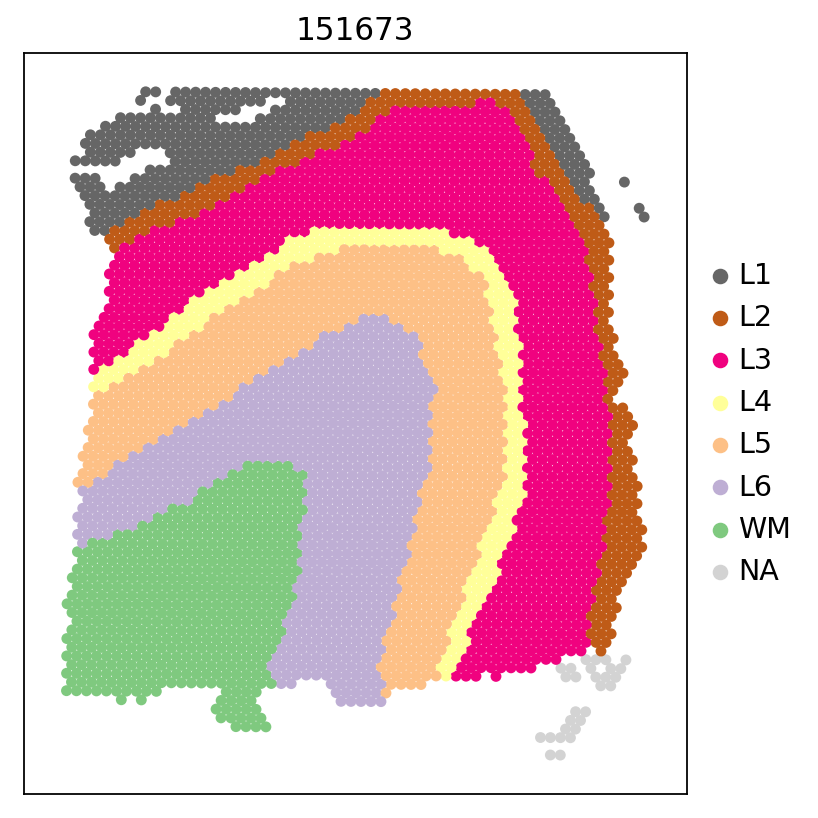

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_d[SAMPLE_ID_N],
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title=SAMPLE_ID_N,
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


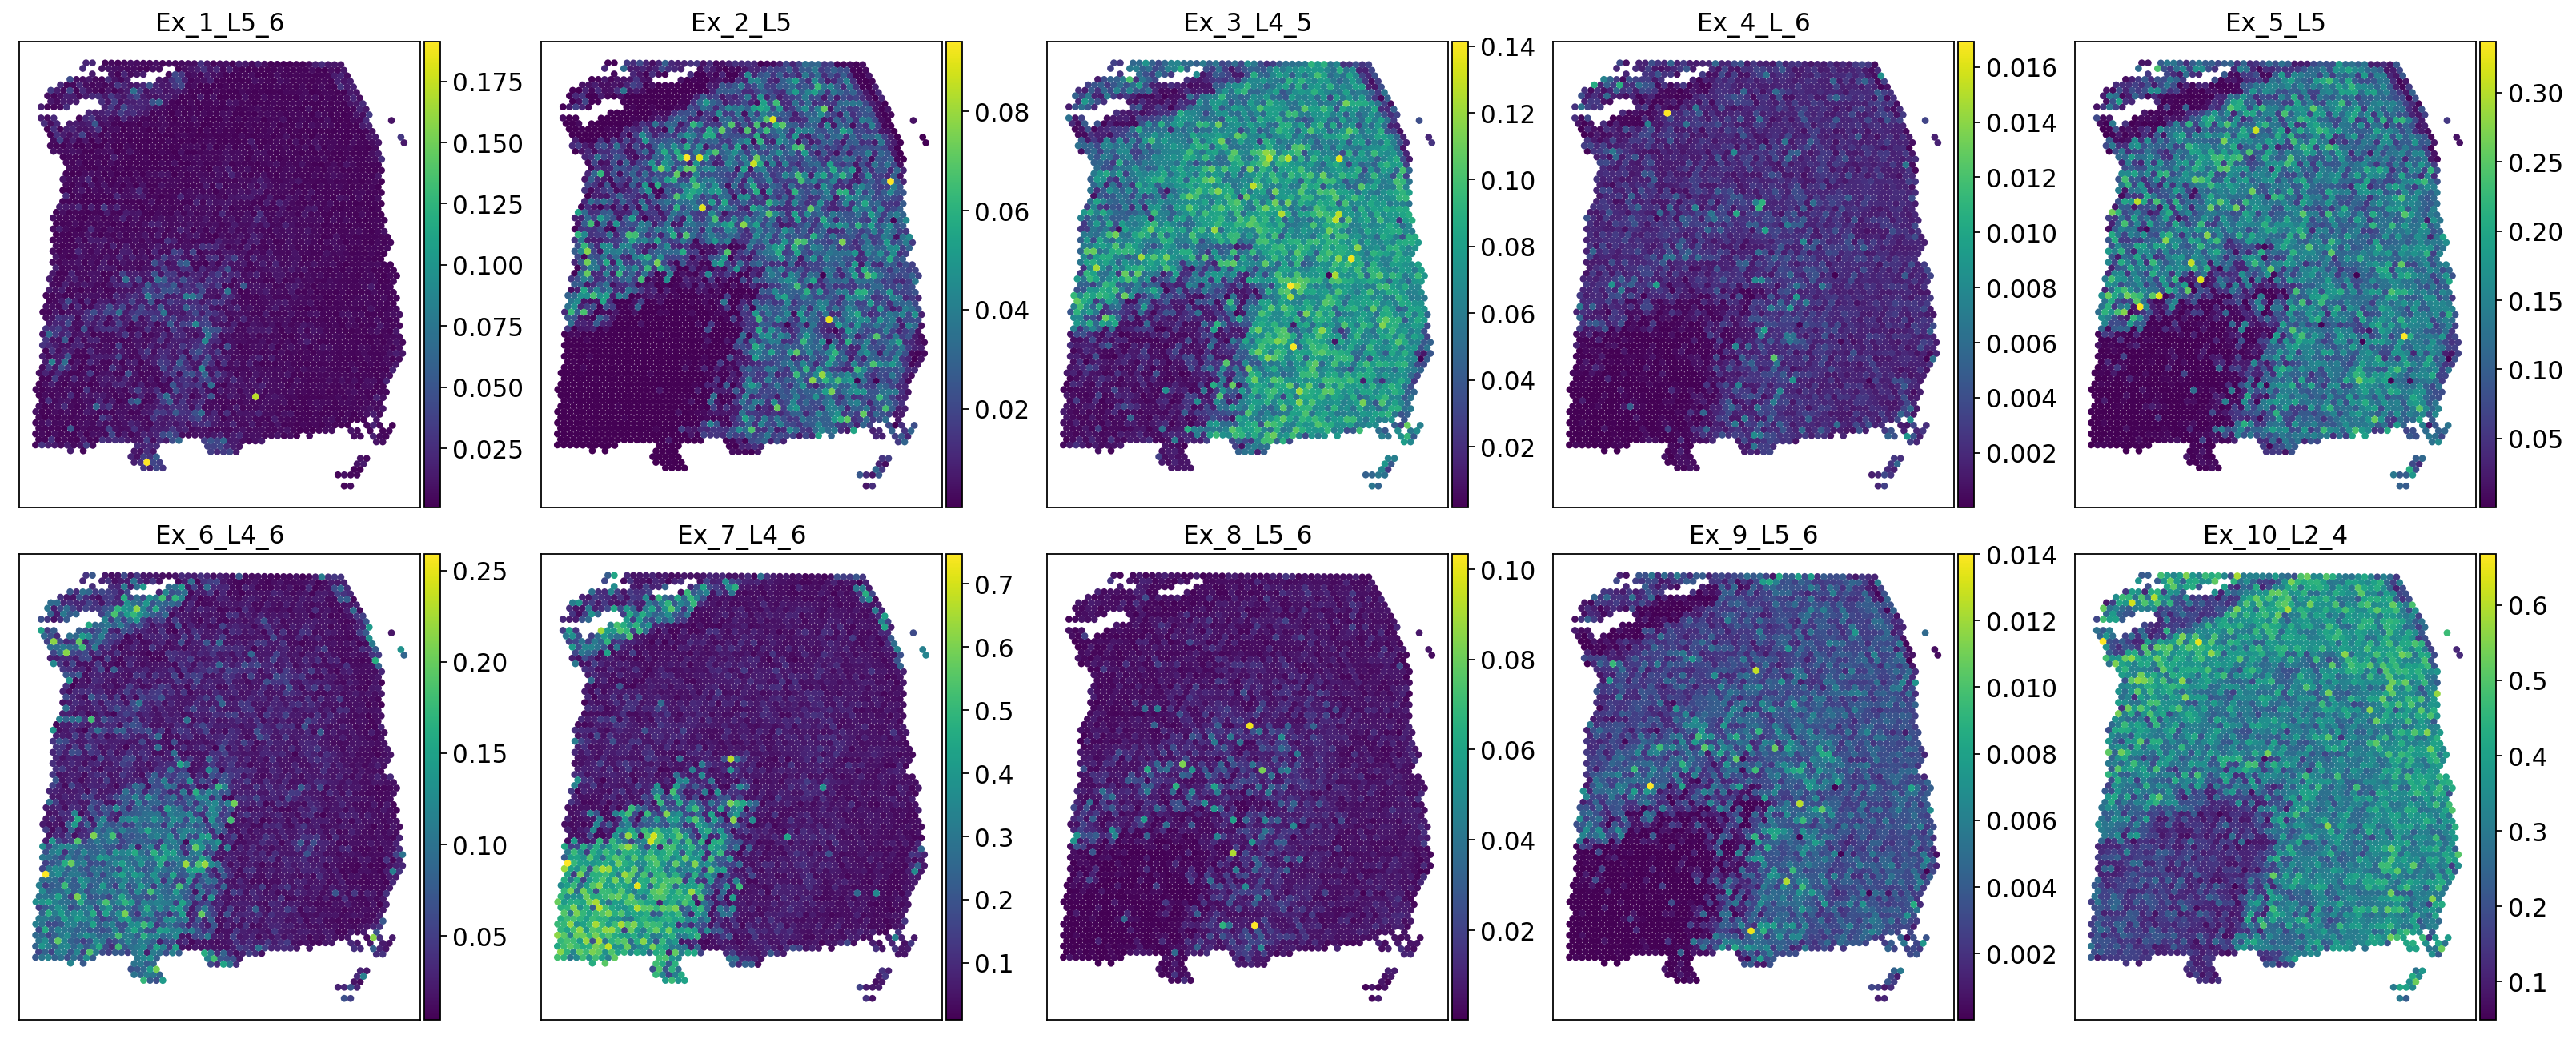

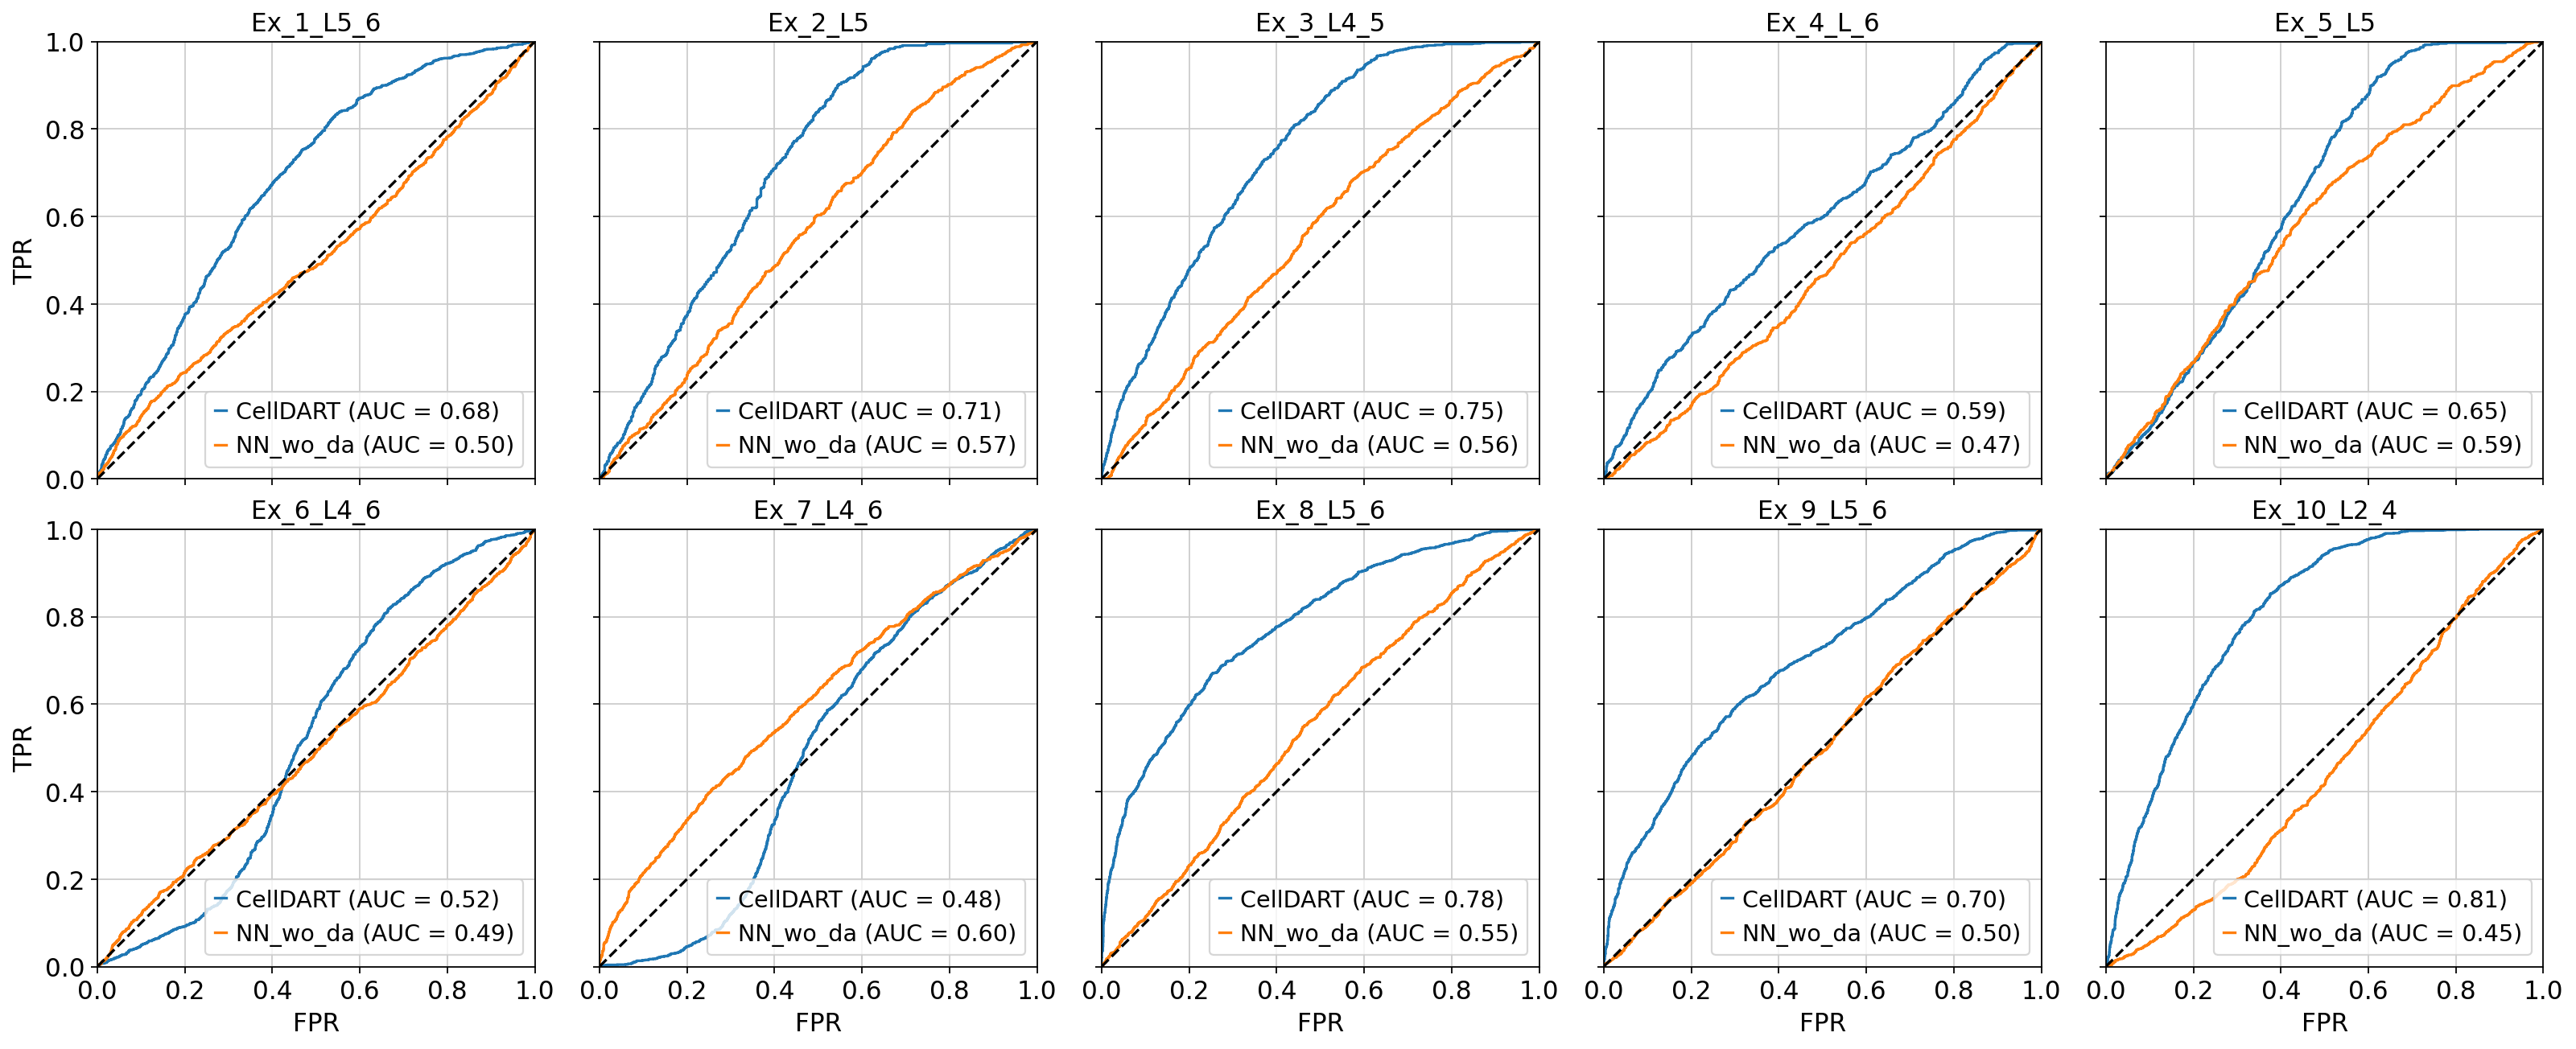

In [93]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(
        num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
    )
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_d[SAMPLE_ID_N],
        "CellDART",
        ax.flat[i],
    )
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_noda_d[SAMPLE_ID_N],
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()


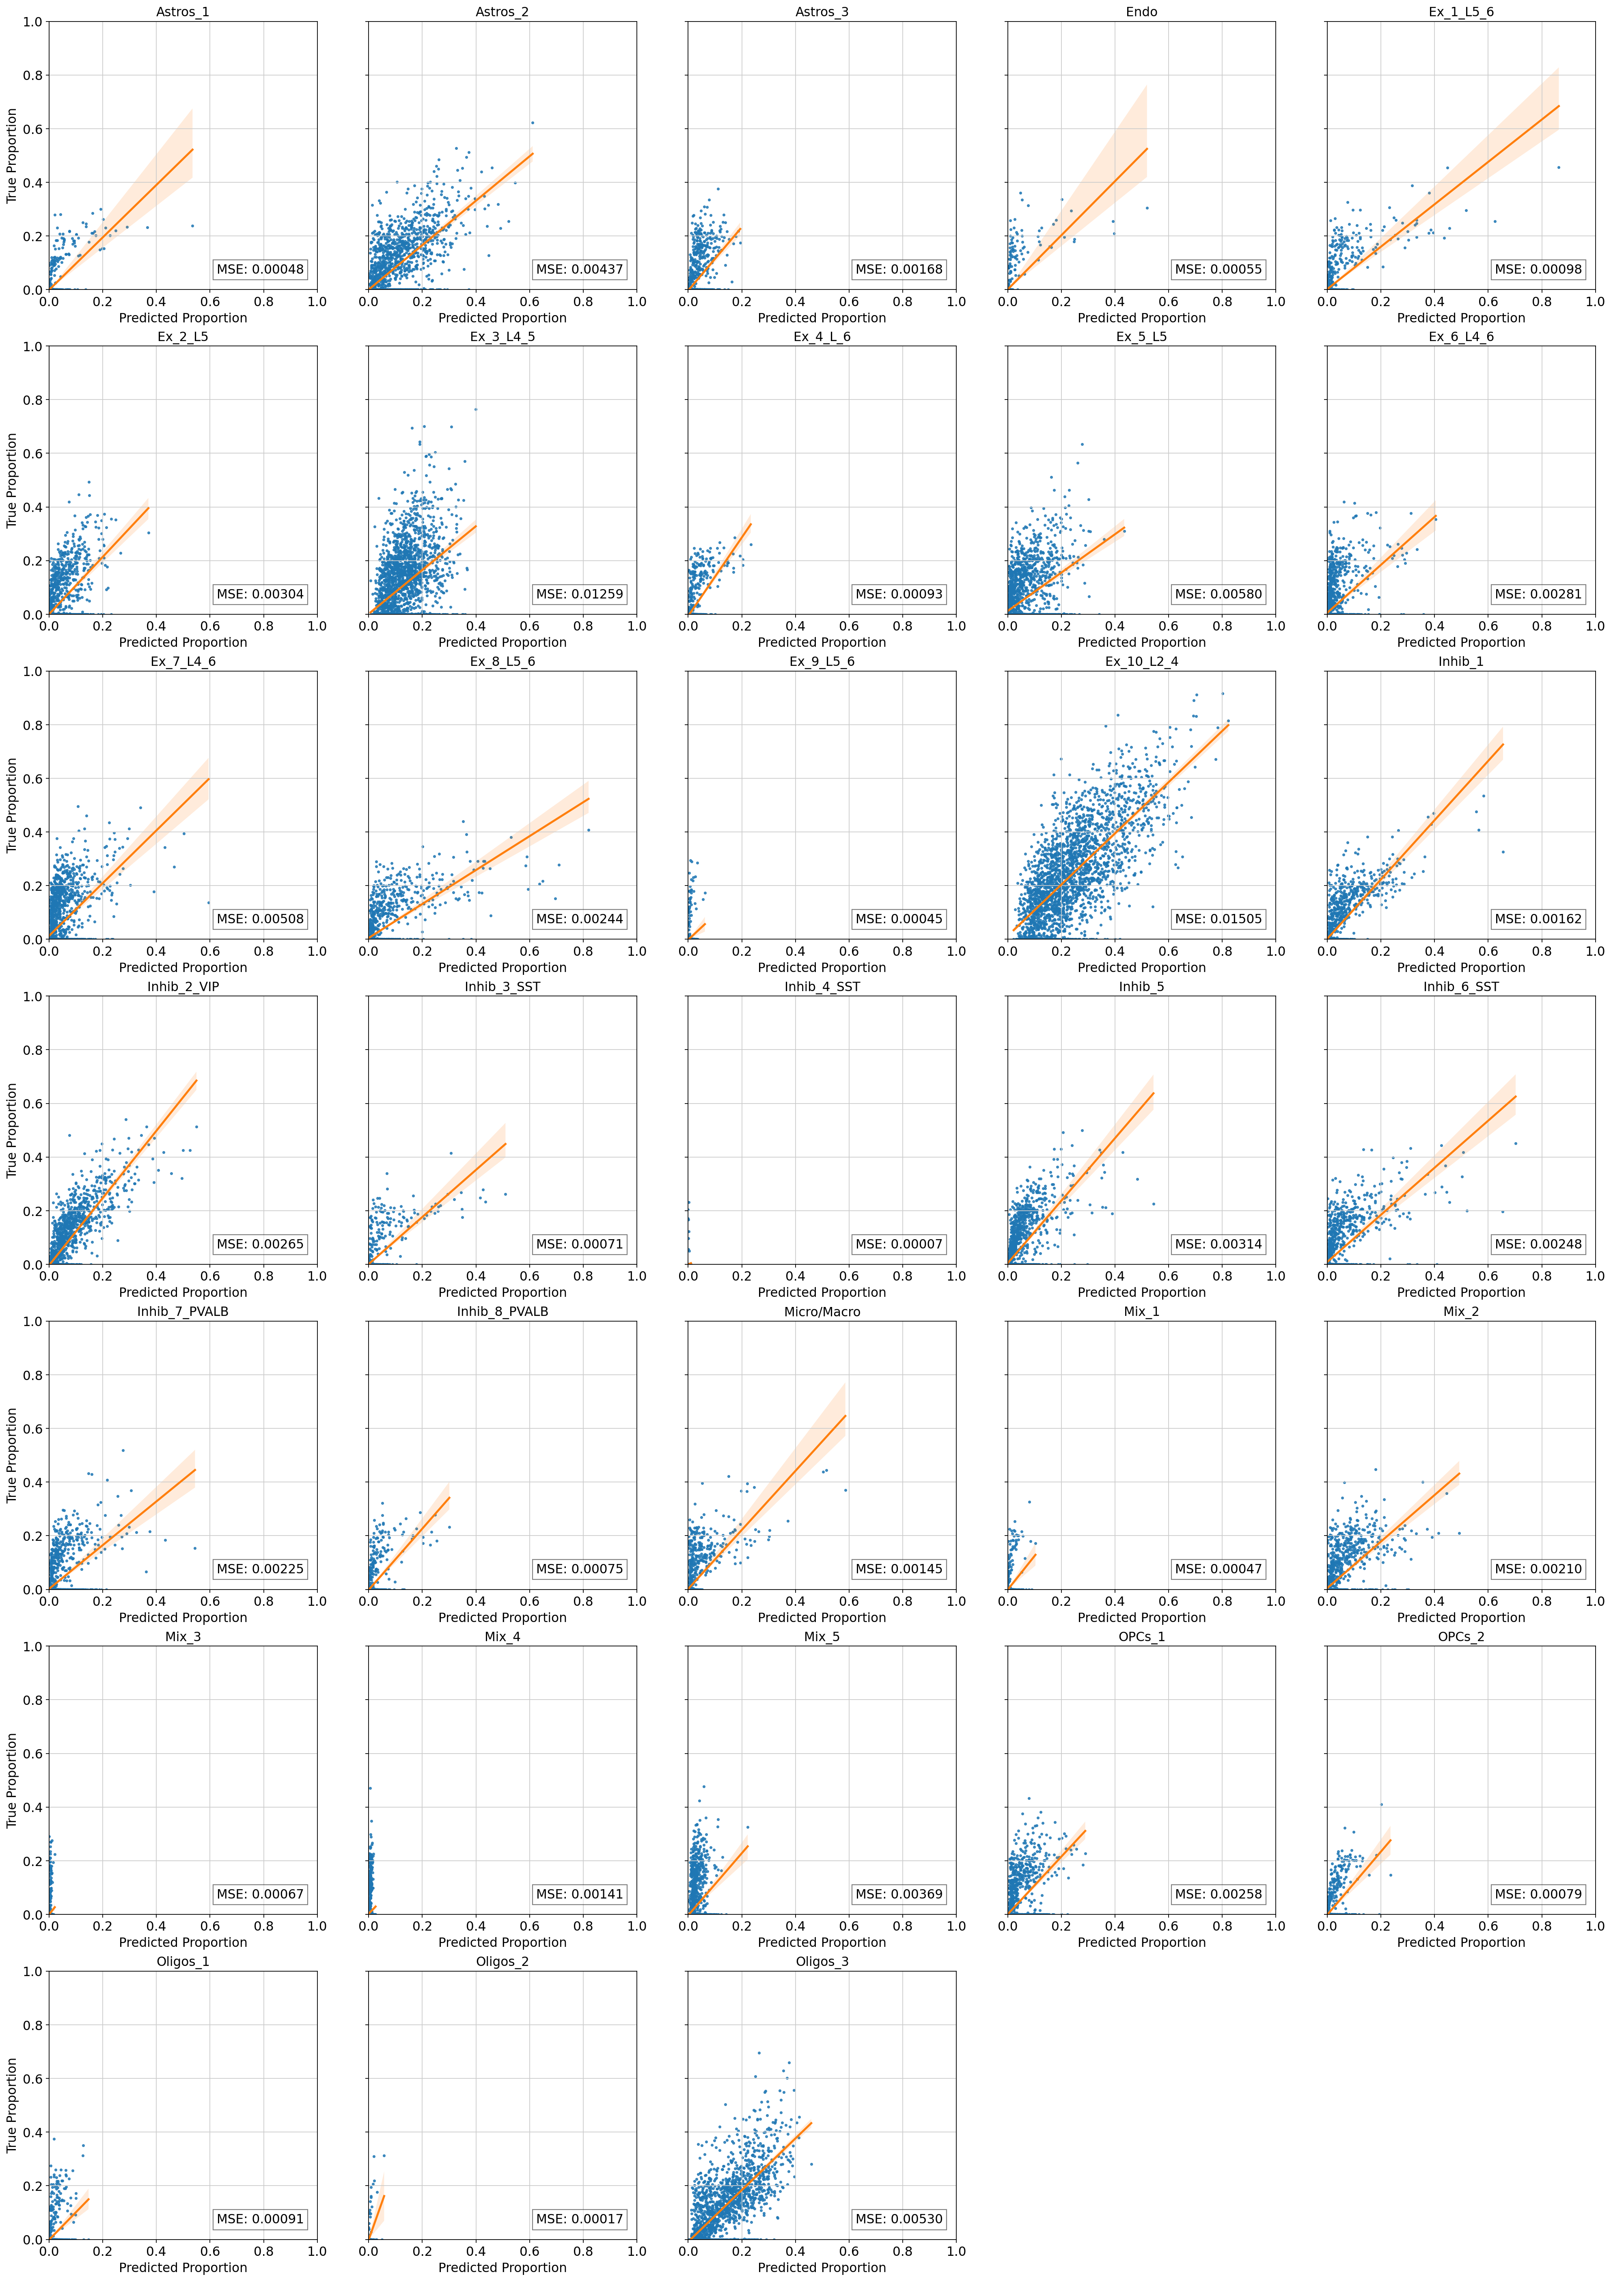

In [94]:
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
else:
    best_checkpoint = torch.load(
        os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
    )

model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

pred_mix = (
    torch.exp(model(torch.Tensor(sc_mix_test_s).to(device)))
    .detach()
    .cpu()
    .numpy()
)

cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {"color": "tab:orange"}
scatter_kws = {"s": 5}

props = dict(facecolor="w", alpha=0.5)

fig, ax = plt.subplots(
    nrows,
    5,
    figsize=(25, 5 * nrows),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)
for i, visnum in enumerate(cell_type_nums):
    sns.regplot(
        x=pred_mix[:, visnum],
        y=lab_mix_test[:, visnum],
        line_kws=line_kws,
        scatter_kws=scatter_kws,
        ax=ax.flat[i],
    ).set_title(sc_sub_dict[visnum])

    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlabel("Predicted Proportion")

    if i % 5 == 0:
        ax.flat[i].set_ylabel("True Proportion")
    else:
        ax.flat[i].set_ylabel("")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    textstr = (
        f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
    )

    # place a text box in upper left in axes coords
    ax.flat[i].text(
        0.95,
        0.05,
        textstr,
        transform=ax.flat[i].transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

for i in range(len(cell_type_nums), nrows * 5):
    ax.flat[i].axis("off")

plt.show()
